## 1. Setup

In [1]:
import sys
sys.path.append('../')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import skimage

from seg_reg_net import SegRegNet
from utils.preprocessing.misc import gaussian_smoothing
from utils.visualization.vis import plot_seg_reg_maps

Using TensorFlow backend.


In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

## 2. SegRegNet

In [4]:
model = SegRegNet(input_shape=(720, 1280, 3), loss_weights=[0.3, 0.7])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 720, 1280, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 720, 1280, 32 896         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 360, 640, 32) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 360, 640, 64) 18496       max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

## Load an image with its GT

In [5]:
def desc_img(img, title=''):
    print(title, img.shape, img.dtype, (img.min(), img.max()), img.sum())

In [6]:
MULT_FACTOR = 2000.

img_path = '../datasets/toy_set/train/images/20161030_GF1_00160.png'
dots_path = '../datasets/toy_set/train/gt_dots/20161030_GF1_00160.png'
img = skimage.io.imread(img_path) / 255.
dots = (skimage.io.imread(dots_path) > 0).astype(np.uint8)
gt_seg_map = (gaussian_smoothing([dots.astype(np.float64)], sigma=10) > 1.5e-4)[..., np.newaxis]
gt_density_map = MULT_FACTOR * gaussian_smoothing([dots.astype(np.float64)], sigma=10)[..., np.newaxis]

desc_img(img,  'img:')
desc_img(dots, 'dots:')
desc_img(gt_seg_map, 'seg_map:')
desc_img(gt_density_map, 'reg_map:')

img: (720, 1280, 3) float64 (0.0, 1.0) 939071.0078431373
dots: (720, 1280) uint8 (0, 1) 42
seg_map: (1, 720, 1280, 1) bool (False, True) 63255
reg_map: (1, 720, 1280, 1) float64 (0.0, 3.1850078085338813) 84000.0


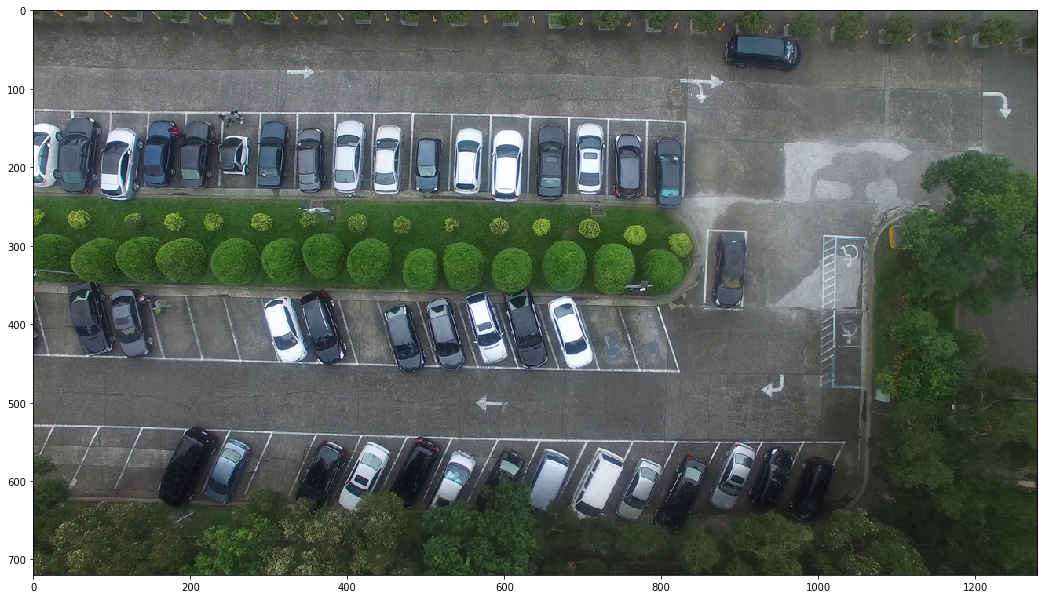

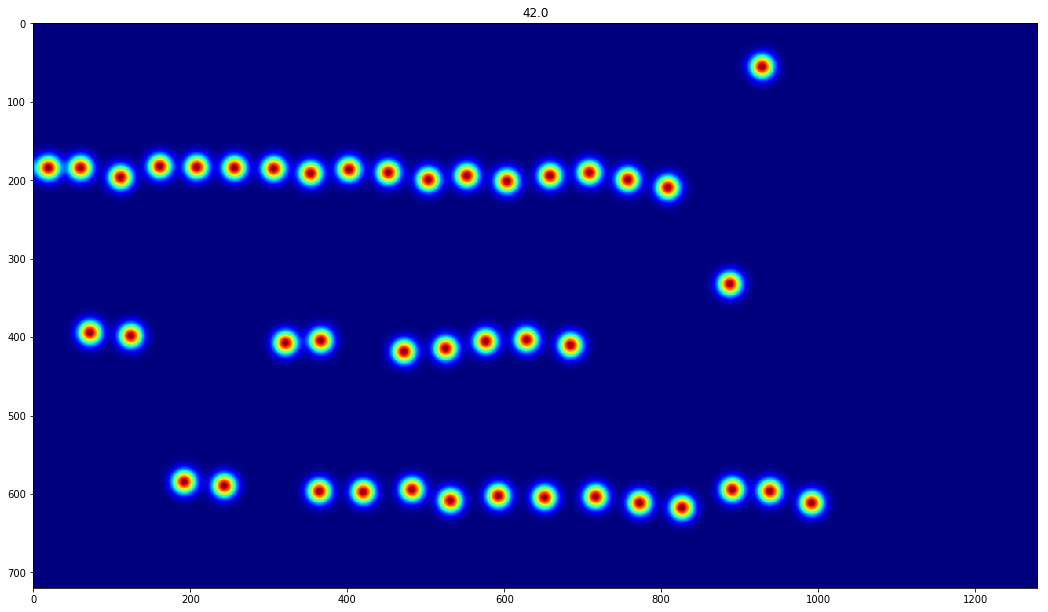

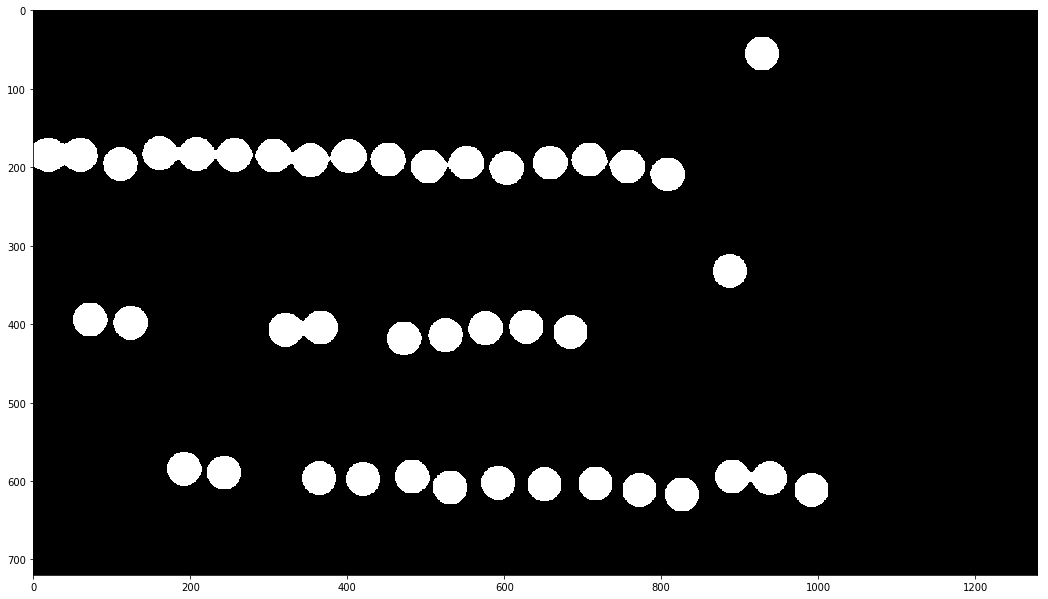

In [8]:
plt.figure(figsize=(18,20))
plt.imshow(img)
plt.figure(figsize=(18,20))
plt.title(gt_density_map.sum()/MULT_FACTOR)
plt.imshow(gt_density_map.squeeze()/MULT_FACTOR, cmap='jet')
plt.figure(figsize=(18,20))
plt.imshow(gt_seg_map.squeeze().astype(np.float32), cmap='gray')
plt.show()

## Predict

In [9]:
preds = model.predict(img[np.newaxis])
print(len(preds))

pred1 = preds[0]
pred2 = preds[1]

desc_img(pred1, 'pred1:')
desc_img(pred2, 'pred2:')

2
pred1: (1, 720, 1280, 1) float32 (0.26568666, 0.6640386) 466888.5
pred2: (1, 720, 1280, 1) float32 (-0.7082789, 1.6089835) 47376.78


## Plot

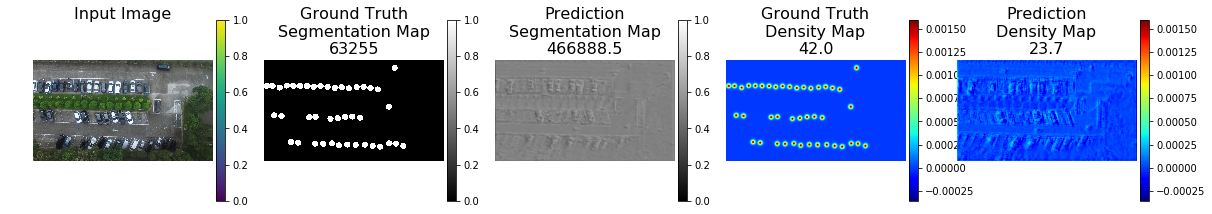

In [10]:
plot_seg_reg_maps(img, gt_seg_map, pred1, gt_density_map, pred2, MULT_FACTOR)

## Train the model on a single example (sanity check)

In [11]:
x = img[np.newaxis]
y = [gt_seg_map, gt_density_map]

Epoch 1/1
 - 7s - loss: 0.2493 - activation_1_loss: 0.7060 - conv2d_12_loss: 0.0535
Epoch 1/1
 - 1s - loss: 2.7495 - activation_1_loss: 0.4607 - conv2d_12_loss: 3.7304
Epoch 1/1
 - 1s - loss: 0.2290 - activation_1_loss: 0.3370 - conv2d_12_loss: 0.1828
Epoch 1/1
 - 1s - loss: 0.1674 - activation_1_loss: 0.3428 - conv2d_12_loss: 0.0923
Epoch 1/1
 - 1s - loss: 0.2516 - activation_1_loss: 0.3235 - conv2d_12_loss: 0.2207
Epoch 1/1
 - 1s - loss: 0.1316 - activation_1_loss: 0.3196 - conv2d_12_loss: 0.0511
Epoch 1/1
 - 1s - loss: 0.1909 - activation_1_loss: 0.3270 - conv2d_12_loss: 0.1326
Epoch 1/1
 - 1s - loss: 0.1338 - activation_1_loss: 0.3196 - conv2d_12_loss: 0.0542
Epoch 1/1
 - 1s - loss: 0.1366 - activation_1_loss: 0.3147 - conv2d_12_loss: 0.0603
Epoch 1/1
 - 1s - loss: 0.1443 - activation_1_loss: 0.3177 - conv2d_12_loss: 0.0700
Epoch 1/1
 - 1s - loss: 0.1267 - activation_1_loss: 0.3148 - conv2d_12_loss: 0.0461
Epoch 1/1
 - 1s - loss: 0.1328 - activation_1_loss: 0.3080 - conv2d_12_loss:

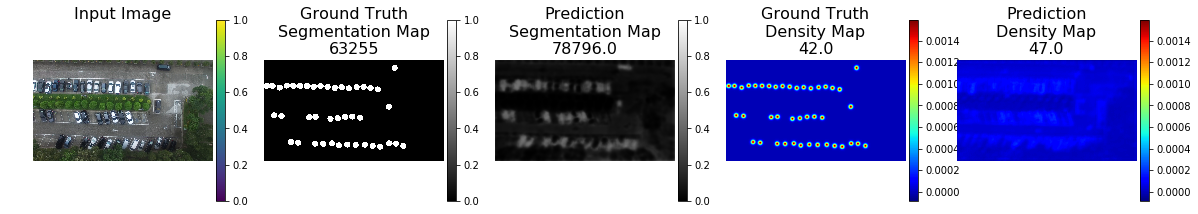

Epoch 1/1
 - 1s - loss: 0.0860 - activation_1_loss: 0.1856 - conv2d_12_loss: 0.0433
Epoch 1/1
 - 1s - loss: 0.0797 - activation_1_loss: 0.1687 - conv2d_12_loss: 0.0416
Epoch 1/1
 - 1s - loss: 0.0813 - activation_1_loss: 0.1659 - conv2d_12_loss: 0.0451
Epoch 1/1
 - 1s - loss: 0.0748 - activation_1_loss: 0.1540 - conv2d_12_loss: 0.0409
Epoch 1/1
 - 1s - loss: 0.0717 - activation_1_loss: 0.1434 - conv2d_12_loss: 0.0410
Epoch 1/1
 - 1s - loss: 0.0755 - activation_1_loss: 0.1583 - conv2d_12_loss: 0.0400
Epoch 1/1
 - 1s - loss: 0.0701 - activation_1_loss: 0.1383 - conv2d_12_loss: 0.0408
Epoch 1/1
 - 1s - loss: 0.0702 - activation_1_loss: 0.1406 - conv2d_12_loss: 0.0400
Epoch 1/1
 - 1s - loss: 0.0687 - activation_1_loss: 0.1349 - conv2d_12_loss: 0.0403
Epoch 1/1
 - 1s - loss: 0.0647 - activation_1_loss: 0.1263 - conv2d_12_loss: 0.0383
Epoch 1/1
 - 1s - loss: 0.0660 - activation_1_loss: 0.1261 - conv2d_12_loss: 0.0403
Epoch 1/1
 - 1s - loss: 0.0673 - activation_1_loss: 0.1369 - conv2d_12_loss:

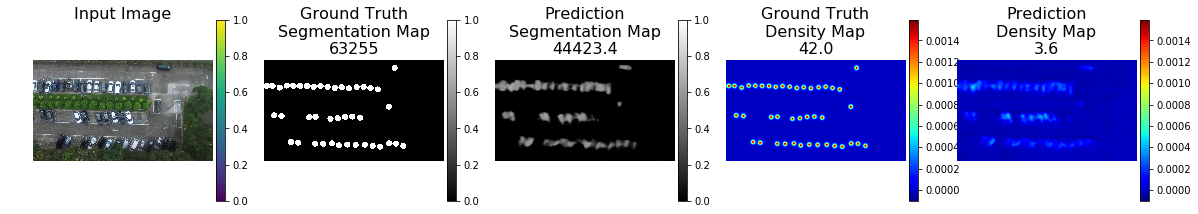

Epoch 1/1
 - 1s - loss: 0.0586 - activation_1_loss: 0.1123 - conv2d_12_loss: 0.0356
Epoch 1/1
 - 1s - loss: 0.0553 - activation_1_loss: 0.1070 - conv2d_12_loss: 0.0332
Epoch 1/1
 - 1s - loss: 0.0558 - activation_1_loss: 0.1101 - conv2d_12_loss: 0.0325
Epoch 1/1
 - 1s - loss: 0.0548 - activation_1_loss: 0.1069 - conv2d_12_loss: 0.0324
Epoch 1/1
 - 1s - loss: 0.0522 - activation_1_loss: 0.1012 - conv2d_12_loss: 0.0312
Epoch 1/1
 - 1s - loss: 0.0532 - activation_1_loss: 0.1030 - conv2d_12_loss: 0.0318
Epoch 1/1
 - 1s - loss: 0.0535 - activation_1_loss: 0.1032 - conv2d_12_loss: 0.0322
Epoch 1/1
 - 1s - loss: 0.0505 - activation_1_loss: 0.0986 - conv2d_12_loss: 0.0299
Epoch 1/1
 - 1s - loss: 0.0487 - activation_1_loss: 0.0945 - conv2d_12_loss: 0.0291
Epoch 1/1
 - 1s - loss: 0.0499 - activation_1_loss: 0.0976 - conv2d_12_loss: 0.0294
Epoch 1/1
 - 1s - loss: 0.0514 - activation_1_loss: 0.1023 - conv2d_12_loss: 0.0296
Epoch 1/1
 - 1s - loss: 0.0511 - activation_1_loss: 0.0984 - conv2d_12_loss:

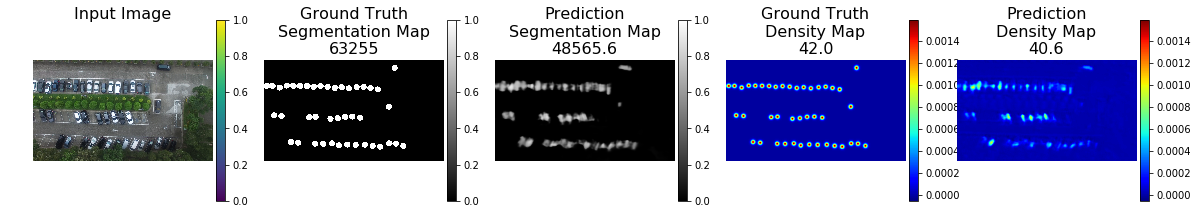

Epoch 1/1
 - 1s - loss: 0.0468 - activation_1_loss: 0.0914 - conv2d_12_loss: 0.0276
Epoch 1/1
 - 1s - loss: 0.0504 - activation_1_loss: 0.0967 - conv2d_12_loss: 0.0306
Epoch 1/1
 - 1s - loss: 0.0440 - activation_1_loss: 0.0881 - conv2d_12_loss: 0.0252
Epoch 1/1
 - 1s - loss: 0.0488 - activation_1_loss: 0.0944 - conv2d_12_loss: 0.0292
Epoch 1/1
 - 1s - loss: 0.0436 - activation_1_loss: 0.0874 - conv2d_12_loss: 0.0248
Epoch 1/1
 - 1s - loss: 0.0461 - activation_1_loss: 0.0915 - conv2d_12_loss: 0.0266
Epoch 1/1
 - 1s - loss: 0.0420 - activation_1_loss: 0.0846 - conv2d_12_loss: 0.0238
Epoch 1/1
 - 1s - loss: 0.0440 - activation_1_loss: 0.0873 - conv2d_12_loss: 0.0255
Epoch 1/1
 - 1s - loss: 0.0412 - activation_1_loss: 0.0813 - conv2d_12_loss: 0.0240
Epoch 1/1
 - 1s - loss: 0.0421 - activation_1_loss: 0.0877 - conv2d_12_loss: 0.0225
Epoch 1/1
 - 1s - loss: 0.0389 - activation_1_loss: 0.0788 - conv2d_12_loss: 0.0217
Epoch 1/1
 - 1s - loss: 0.0404 - activation_1_loss: 0.0814 - conv2d_12_loss:

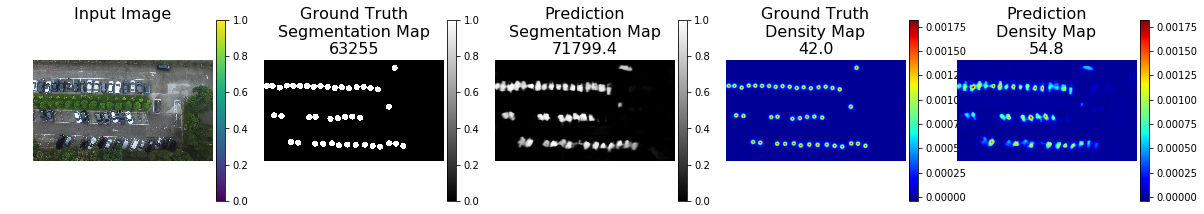

Epoch 1/1
 - 1s - loss: 0.0346 - activation_1_loss: 0.0697 - conv2d_12_loss: 0.0196
Epoch 1/1
 - 1s - loss: 0.0336 - activation_1_loss: 0.0702 - conv2d_12_loss: 0.0179
Epoch 1/1
 - 1s - loss: 0.0322 - activation_1_loss: 0.0673 - conv2d_12_loss: 0.0172
Epoch 1/1
 - 1s - loss: 0.0313 - activation_1_loss: 0.0646 - conv2d_12_loss: 0.0170
Epoch 1/1
 - 1s - loss: 0.0303 - activation_1_loss: 0.0637 - conv2d_12_loss: 0.0161
Epoch 1/1
 - 1s - loss: 0.0296 - activation_1_loss: 0.0622 - conv2d_12_loss: 0.0157
Epoch 1/1
 - 1s - loss: 0.0293 - activation_1_loss: 0.0620 - conv2d_12_loss: 0.0153
Epoch 1/1
 - 1s - loss: 0.0301 - activation_1_loss: 0.0621 - conv2d_12_loss: 0.0163
Epoch 1/1
 - 1s - loss: 0.0395 - activation_1_loss: 0.0827 - conv2d_12_loss: 0.0209
Epoch 1/1
 - 1s - loss: 0.0646 - activation_1_loss: 0.1463 - conv2d_12_loss: 0.0295
Epoch 1/1
 - 1s - loss: 0.0969 - activation_1_loss: 0.2250 - conv2d_12_loss: 0.0420
Epoch 1/1
 - 1s - loss: 0.0499 - activation_1_loss: 0.0800 - conv2d_12_loss:

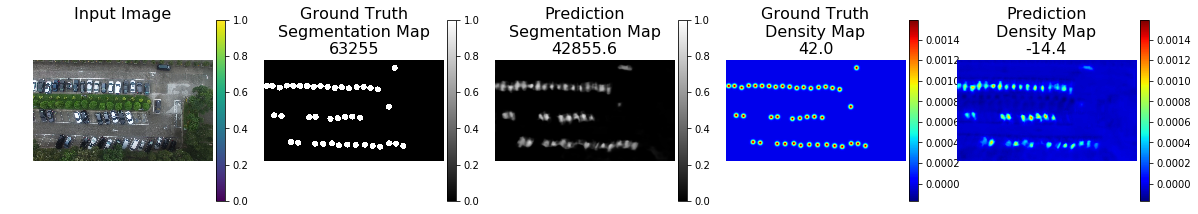

In [12]:
for i in range(100):
    model.fit(x, y, verbose=2)
    pred1, pred2 = model.predict(x)
    if (i + 1) % 20 == 0:
        print(f'Epoch {i+1:2d}:')
        plot_seg_reg_maps(img, gt_seg_map, pred1, gt_density_map, pred2, MULT_FACTOR)